## Loading data

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import glob

DATA_DIR = 'dataset'

# Create directory
IMAGE_DATASET_PATH = glob.glob(os.path.join(DATA_DIR, 'image', '*.jpg'))
MASK_DATASET_PATH = glob.glob(os.path.join(DATA_DIR, 'mask', '*.jpg'))

In [3]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

C:\Users\jimmy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [4]:
from sklearn.model_selection import train_test_split

TEST_SPLIT=0.1
VAL_SPLIT=0.15

# load the image and mask filepaths in a sorted manner
imagePaths = sorted(IMAGE_DATASET_PATH)
maskPaths = sorted(MASK_DATASET_PATH)

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(imagePaths, maskPaths,
                         test_size=TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for validation
split = train_test_split(trainImages, trainMasks,
                         test_size=VAL_SPLIT, random_state=42)

# unpack the data split
(trainImages, valImages) = split[:2]
(trainMasks, valMasks) = split[2:]

In [5]:
print('train samples: ', len(trainImages))
print('validation samples: ', len(valImages))
print('test samples: ', len(testImages))

train samples:  804
validation samples:  143
test samples:  106


In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #            'tree', 'signsymbol', 'fence', 'car', 
    #            'pedestrian', 'bicyclist', 'unlabelled']
    
    CLASSES = ['not_tumor', 'tumor']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        # self.ids = os.listdir(images_dir)
        self.images_fps = images_dir
        self.masks_fps = masks_dir
        
        # # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask != v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

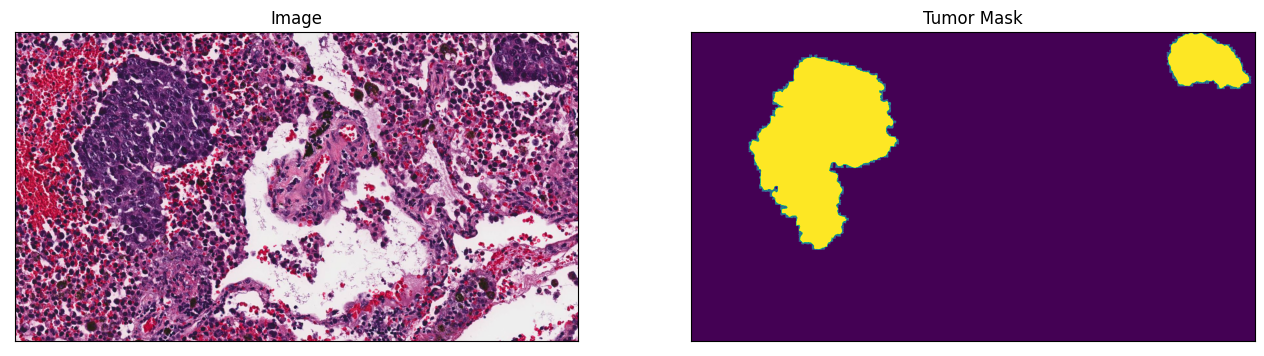

In [9]:
# Lets look at data we have

dataset = Dataset(trainImages, trainMasks, classes=['not_tumor']) 

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    tumor_mask=mask.squeeze(),
)

## Augmentations
Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.

In [10]:
import albumentations as albu

In [11]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=480, min_width=864, always_apply=True, border_mode=0),
        albu.RandomCrop(height=480, width=864, always_apply=True),

        albu.augmentations.transforms.GaussNoise(p=0.2),
        albu.augmentations.geometric.transforms.Perspective(p=0.5),
        # albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.augmentations.transforms.Sharpen(p=1),
                # albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(480, 864),
        albu.PadIfNeeded(480, 864)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

C:\Users\jimmy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\jimmy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


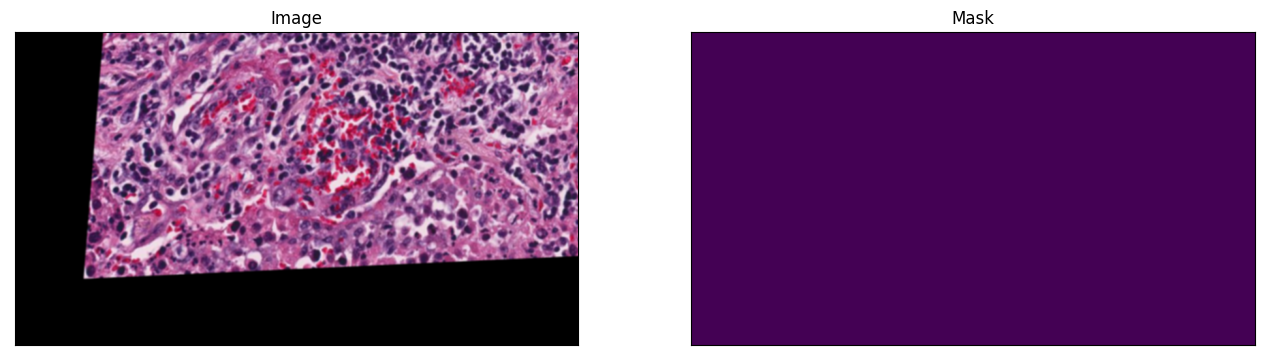

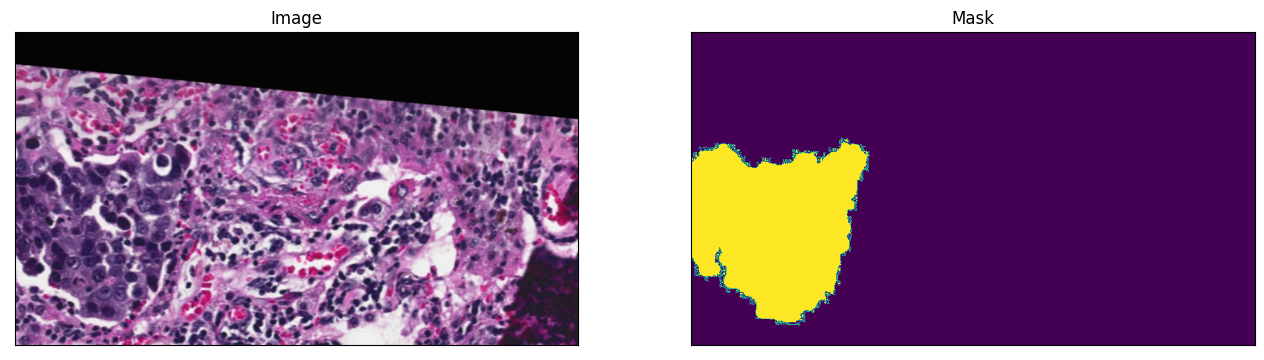

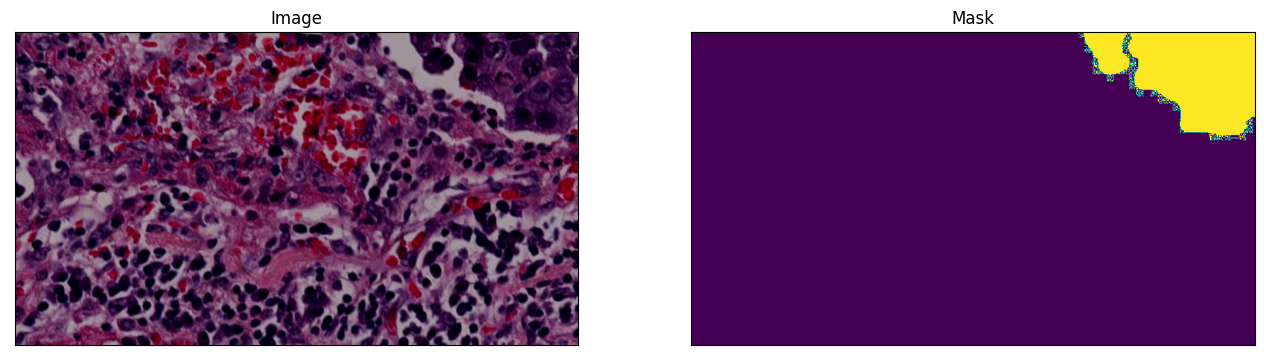

In [12]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    trainImages, 
    trainMasks, 
    augmentation=get_training_augmentation(), 
    classes=['not_tumor'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [14]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['cars']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [16]:
train_dataset = Dataset(
    trainImages, 
    trainMasks, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['not_tumor'],
)

valid_dataset = Dataset(
    valImages, 
    valMasks, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['not_tumor'],
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # , num_workers=12
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)  # , num_workers=4

C:\Users\jimmy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\jimmy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [17]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
from segmentation_models_pytorch import utils

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [18]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 143/143 [00:30<00:00,  4.69it/s, dice_loss - 0.8391, iou_score - 0.2388]
Model saved!

Epoch: 1
valid: 100%|██████████| 143/143 [00:29<00:00,  4.93it/s, dice_loss - 0.677, iou_score - 0.2731] 
Model saved!

Epoch: 2
valid: 100%|██████████| 143/143 [00:27<00:00,  5.22it/s, dice_loss - 0.7737, iou_score - 0.1901]

Epoch: 3
valid: 100%|██████████| 143/143 [00:27<00:00,  5.13it/s, dice_loss - 0.7276, iou_score - 0.2262]

Epoch: 4
valid: 100%|██████████| 143/143 [00:27<00:00,  5.14it/s, dice_loss - 0.7166, iou_score - 0.2371]

Epoch: 5
valid: 100%|██████████| 143/143 [00:27<00:00,  5.20it/s, dice_loss - 0.626, iou_score - 0.3129] 
Model saved!

Epoch: 6
valid: 100%|██████████| 143/143 [00:28<00:00,  5.03it/s, dice_loss - 0.6289, iou_score - 0.3164]
Model saved!

Epoch: 7
valid: 100%|██████████| 143/143 [00:27<00:00,  5.15it/s, dice_loss - 0.6977, iou_score - 0.258] 

Epoch: 8
valid: 100%|██████████| 143/143 [00:28<00:00,  5.05it/s, dice_loss - 0.6527, iou_s

## Test best saved model

In [20]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [21]:
# create test dataset
test_dataset = Dataset(
    testImages, 
    testMasks, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['not_tumor'],
)

test_dataloader = DataLoader(test_dataset)

In [22]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 106/106 [00:19<00:00,  5.32it/s, dice_loss - 0.6023, iou_score - 0.3258] 


## Visualize predictions

In [23]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    testImages, testMasks, 
    classes=['not_tumor'],
)

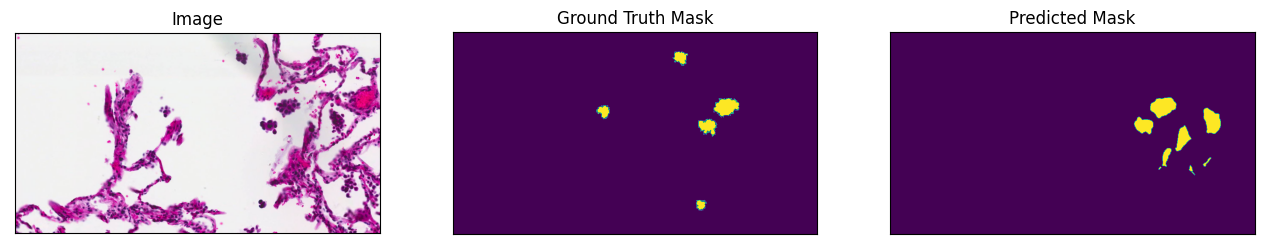

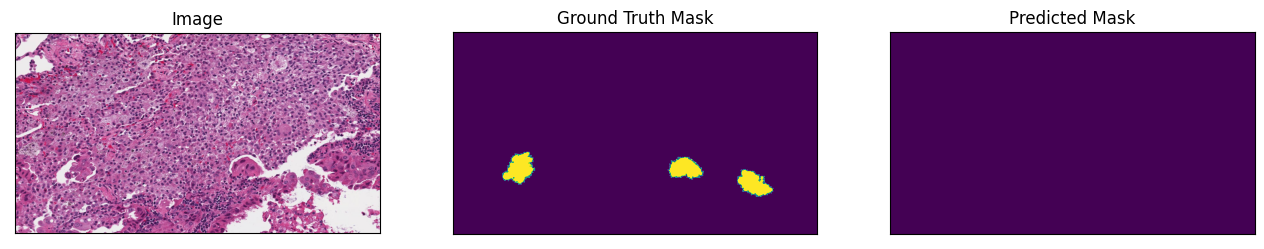

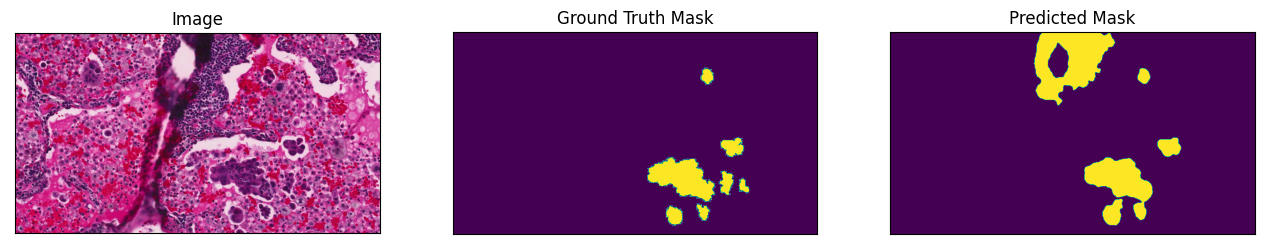

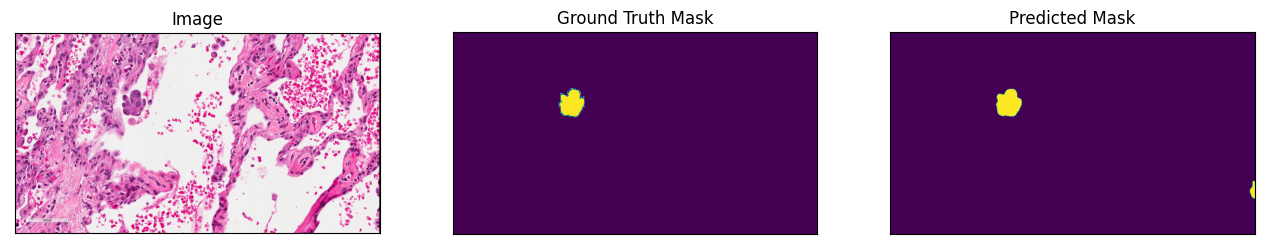

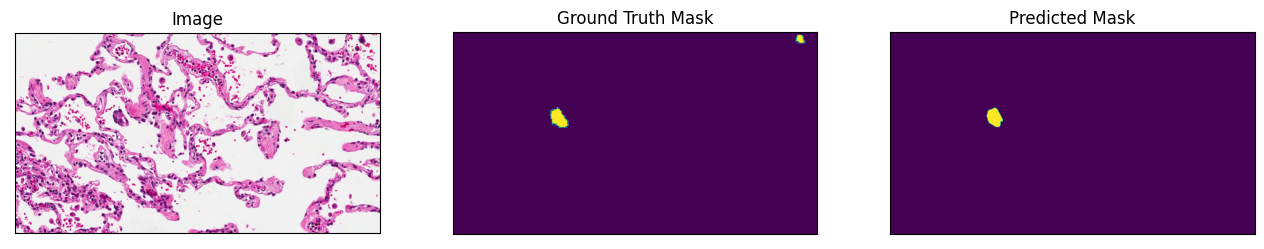

In [24]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )